In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import struct
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import os

# ---------------------- 数据读取部分（保持不变） ----------------------
def read_idx_images(file_path):
    """读取IDX格式的图像文件"""
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    return images  # shape: (样本数, 28, 28)

def read_idx_labels(file_path):
    """读取IDX格式的标签文件"""
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels  # shape: (样本数,)

class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = read_idx_images(images_path)
        self.labels = read_idx_labels(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0  # 归一化到[0,1]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return torch.tensor(image).unsqueeze(0), torch.tensor(label)  # 增加通道维度

# ---------------------- ResNet核心组件 ----------------------
class ResidualBlock(nn.Module):
    """残差块实现"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # 主路径卷积
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 跳跃连接（当通道数或尺寸变化时调整）
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)  # 残差连接
        out = self.relu(out)
        return out

# ---------------------- ResNet模型定义 ----------------------
class MNISTResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MNISTResNet, self).__init__()
        # 初始卷积层（适应MNIST 28x28输入）
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)  # 输入(1,28,28)->(16,28,28)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # (16,14,14)
        
        # 残差块堆叠（2个残差块组）
        self.layer1 = self._make_layer(16, 32, num_blocks=2, stride=2)  # (32,7,7)
        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=2)  # (64,3,3) 注：实际计算(7-2)/2+1=3
        
        # 全局平均池化 + 全连接层
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # (64,1,1)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        """构建残差块组"""
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(in_channels, out_channels, stride))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# ---------------------- 训练流程部分（保持不变） ----------------------
def train_model(train_loader, model, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (batch_idx+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0
    return model

# ---------------------- 测试评估部分（保持不变） ----------------------
def evaluate_model(test_loader, model, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, 
        average='macro', 
        zero_division=0
    )
    
    class_report = classification_report(
        all_labels, all_preds,
        target_names=[str(i) for i in range(10)],
        output_dict=True
    )
    
    return {
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1': round(f1, 4),
        'class_report': class_report,
        'true_labels': all_labels,
        'pred_labels': all_preds
    }

# ---------------------- 主程序（仅修改模型类名） ----------------------
if __name__ == "__main__":
    DATA_DIR = ''  # 数据文件存放路径
    TRAIN_IMAGES = os.path.join(DATA_DIR, 'train-images.idx3-ubyte')
    TRAIN_LABELS = os.path.join(DATA_DIR, 'train-labels.idx1-ubyte')
    TEST_IMAGES = os.path.join(DATA_DIR, 't10k-images.idx3-ubyte')
    TEST_LABELS = os.path.join(DATA_DIR, 't10k-labels.idx1-ubyte')
    
    BATCH_SIZE = 128
    EPOCHS = 50  # ResNet收敛更快，可适当减少训练轮数
    LEARNING_RATE = 0.001
    MODEL_PATH = '2/mnist_resnet_classifier_50.pth'
    RESULT_PATH = '2/resnet_prediction_results_50.csv'
    METRICS_PATH = '2/resnet_evaluation_metrics_50.csv'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 数据加载（保持不变）
    train_dataset = MNISTDataset(TRAIN_IMAGES, TRAIN_LABELS)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    test_dataset = MNISTDataset(TEST_IMAGES, TEST_LABELS)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 模型初始化（改为ResNet）
    model = MNISTResNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练模型（保持不变）
    print("开始训练...")
    model = train_model(train_loader, model, criterion, optimizer, EPOCHS, device)

    # 保存模型（保持不变）
    torch.save(model.state_dict(), MODEL_PATH)
    print(f'模型已保存至 {MODEL_PATH}')

    # 加载模型（保持不变）
    loaded_model = MNISTResNet().to(device)
    loaded_model.load_state_dict(torch.load(MODEL_PATH))

    # 评估测试集（保持不变）
    print("开始评估测试集...")
    eval_results = evaluate_model(test_loader, loaded_model, device)

    # 保存结果（保持不变）
    results_df = pd.DataFrame({
        'sample_index': range(len(eval_results['true_labels'])),
        'true_label': eval_results['true_labels'],
        'pred_label': eval_results['pred_labels']
    })
    results_df.to_csv(RESULT_PATH, index=False)
    print(f'预测结果已保存至 {RESULT_PATH}')

    metrics_df = pd.DataFrame({
        'metric': ['accuracy', 'precision', 'recall', 'f1'],
        'value': [
            eval_results['accuracy'],
            eval_results['precision'],
            eval_results['recall'],
            eval_results['f1']
        ]
    })
    metrics_df.to_csv(METRICS_PATH, index=False)
    print(f'评估指标已保存至 {METRICS_PATH}')

    # 打印指标（保持不变）
    print("\n===== 总体评估指标 =====")
    print(f"准确率: {eval_results['accuracy']}")
    print(f"宏平均精确率: {eval_results['precision']}")
    print(f"宏平均召回率: {eval_results['recall']}")
    print(f"宏平均F1值: {eval_results['f1']}")
    
    print("\n===== 各类别详细指标 =====")
    print(classification_report(
        eval_results['true_labels'], 
        eval_results['pred_labels'],
        target_names=[str(i) for i in range(10)]
    ))
    

开始训练...
Epoch [1/50], Batch [100/469], Loss: 0.4649
Epoch [1/50], Batch [200/469], Loss: 0.1098
Epoch [1/50], Batch [300/469], Loss: 0.0828
Epoch [1/50], Batch [400/469], Loss: 0.0662
Epoch [2/50], Batch [100/469], Loss: 0.0470
Epoch [2/50], Batch [200/469], Loss: 0.0453
Epoch [2/50], Batch [300/469], Loss: 0.0429
Epoch [2/50], Batch [400/469], Loss: 0.0481
Epoch [3/50], Batch [100/469], Loss: 0.0303
Epoch [3/50], Batch [200/469], Loss: 0.0332
Epoch [3/50], Batch [300/469], Loss: 0.0271
Epoch [3/50], Batch [400/469], Loss: 0.0358
Epoch [4/50], Batch [100/469], Loss: 0.0260
Epoch [4/50], Batch [200/469], Loss: 0.0258
Epoch [4/50], Batch [300/469], Loss: 0.0241
Epoch [4/50], Batch [400/469], Loss: 0.0276
Epoch [5/50], Batch [100/469], Loss: 0.0152
Epoch [5/50], Batch [200/469], Loss: 0.0199
Epoch [5/50], Batch [300/469], Loss: 0.0181
Epoch [5/50], Batch [400/469], Loss: 0.0219
Epoch [6/50], Batch [100/469], Loss: 0.0137
Epoch [6/50], Batch [200/469], Loss: 0.0141
Epoch [6/50], Batch [300

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12256\3732857164.py:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(MODEL_PATH

预测结果已保存至 2/resnet_prediction_results_50.csv
评估指标已保存至 2/resnet_evaluation_metrics_50.csv

===== 总体评估指标 =====
准确率: 0.9913
宏平均精确率: 0.9912
宏平均召回率: 0.9913
宏平均F1值: 0.9912

===== 各类别详细指标 =====
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



ResNet模型加载成功（设备: cuda）

正在使用ResNet模型处理文件夹: 手写数字图像/1（已启用颜色反转）
已处理: 0.jpg → 预测: 0（置信度: 100.0%）
已处理: 1.jpg → 预测: 1（置信度: 99.8%）
已处理: 2.jpg → 预测: 2（置信度: 45.8%）
已处理: 3.jpg → 预测: 3（置信度: 61.6%）
已处理: 4.jpg → 预测: 4（置信度: 100.0%）
已处理: 5.jpg → 预测: 5（置信度: 100.0%）
已处理: 6.jpg → 预测: 6（置信度: 88.2%）
已处理: 7.jpg → 预测: 7（置信度: 99.9%）
已处理: 8.jpg → 预测: 8（置信度: 100.0%）
已处理: 9.jpg → 预测: 9（置信度: 99.5%）
完成 10 张图片的预测
汇总图已保存至: resnet1_50.png


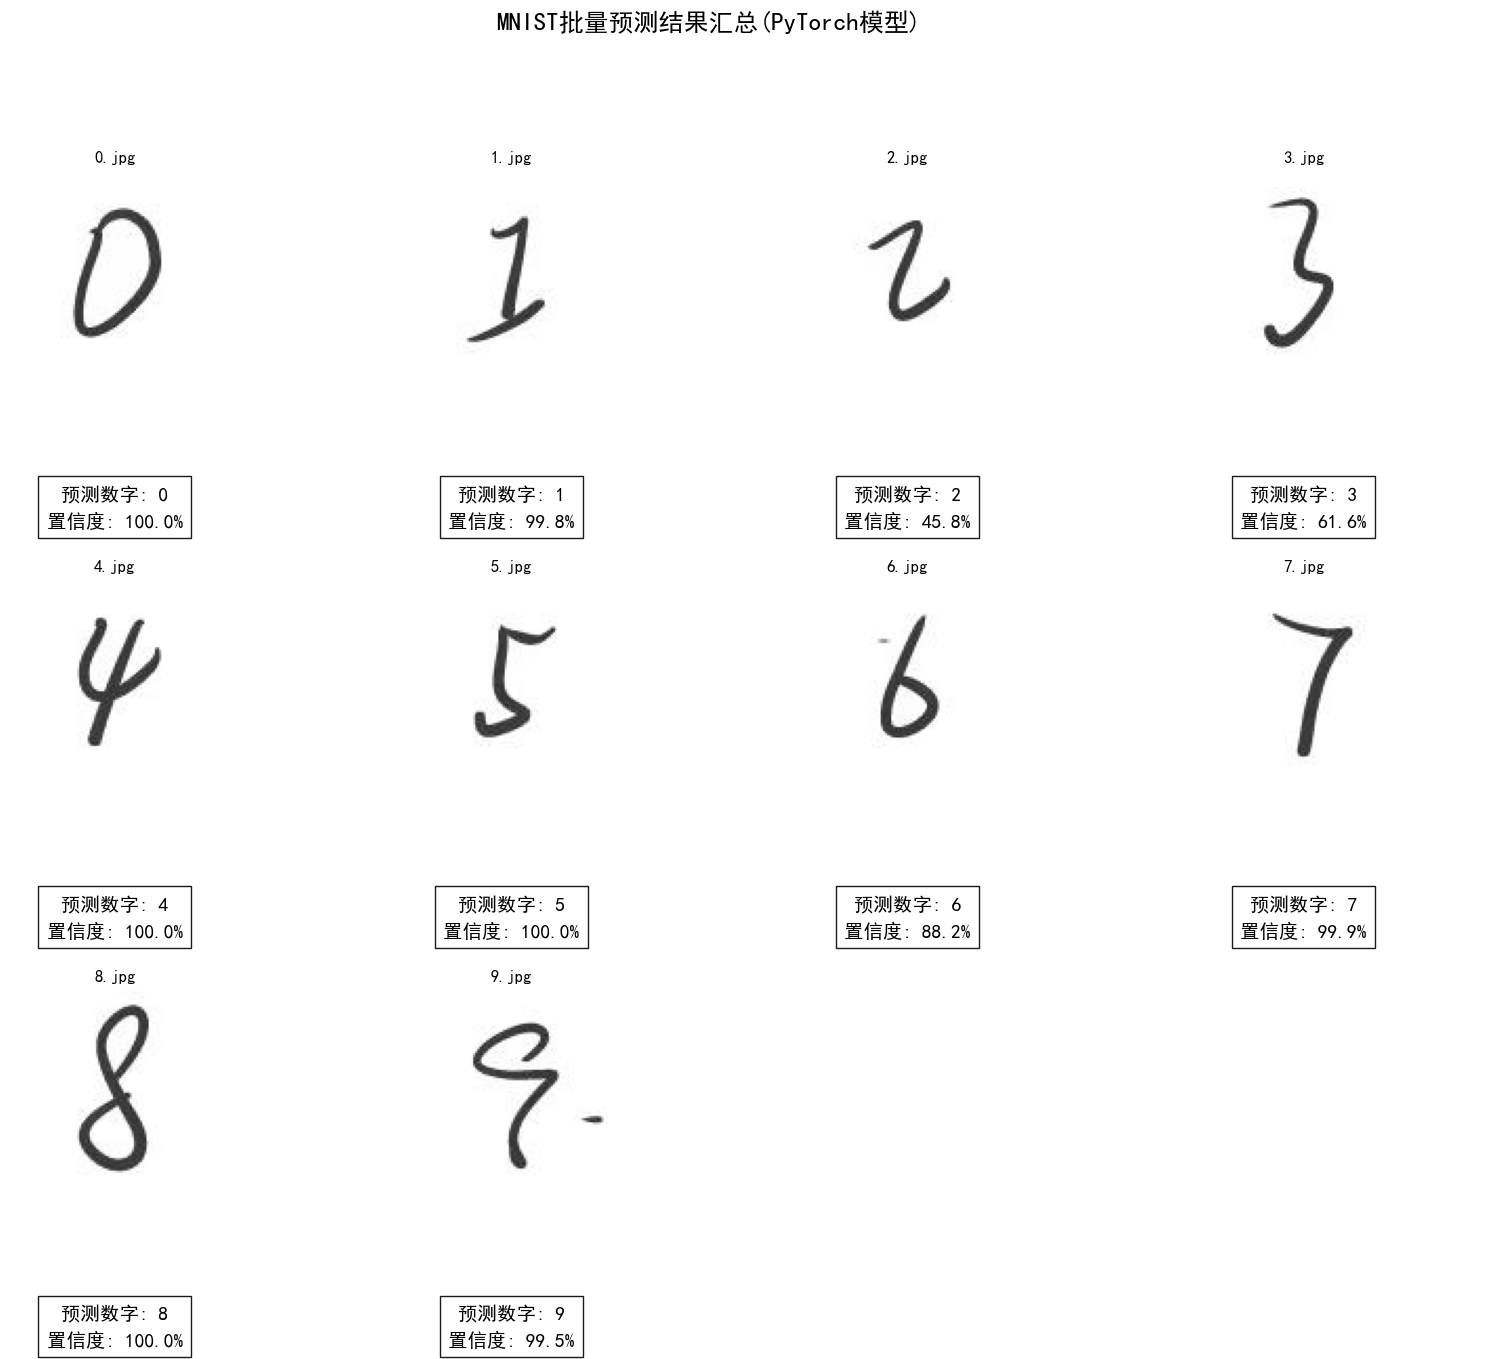

In [18]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.font_manager as fm

# ---------------------- PyTorch模型定义（修正ResidualBlock） ----------------------
class MNISTResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)  # 定义公共ReLU层
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.layer1 = self._make_layer(16, 32, num_blocks=2, stride=2)
        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(in_channels, out_channels, stride, relu=self.relu))  # 传递公共ReLU层
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ResidualBlock(nn.Module):
    """修正后的残差块（包含ReLU属性）"""
    def __init__(self, in_channels, out_channels, stride=1, relu=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 接收来自父模块的ReLU层（避免重复定义）
        self.relu = relu if relu is not None else nn.ReLU(inplace=True)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)  # 使用定义好的ReLU层
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)  # 第二次激活
        return out

# ---------------------- 核心功能函数（修正模型加载） ----------------------
def load_pytorch_model(model_path='mnist_resnet_classifier.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MNISTResNet().to(device)
    try:
        # 显式设置weights_only=True（避免FutureWarning）
        state_dict = torch.load(model_path, map_location=device, weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        print(f"ResNet模型加载成功（设备: {device}）")
        return model, device
    except Exception as e:
        raise RuntimeError(f"模型加载失败: {str(e)}")

# ---------------------- 其他函数（保持不变） ----------------------
def preprocess_image(image_path, target_size=(28, 28)):
    img = Image.open(image_path).convert('L')
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img, dtype=np.float32)
    img_array = 255.0 - img_array  # 颜色反转
    img_array = img_array / 255.0
    return transforms.ToTensor()(img_array).unsqueeze(0)

def predict_image(image_path, model, device):
    input_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_label = torch.argmax(probs).item()
        confidence = probs.max().item()
    return {
        'image_path': image_path,
        'pred_label': pred_label,
        'confidence': confidence
    }

def batch_predict(image_folder, model, device):
    """批量预测文件夹中的所有图片"""
    image_paths = glob(os.path.join(image_folder, '*.png')) + \
                  glob(os.path.join(image_folder, '*.jpg')) + \
                  glob(os.path.join(image_folder, '*.jpeg'))
    
    results = []
    for img_path in image_paths:
        try:
            results.append(predict_image(img_path, model, device))
            print(f"已处理: {os.path.basename(img_path)} → 预测: {results[-1]['pred_label']}（置信度: {results[-1]['confidence']*100:.1f}%）")
        except Exception as e:
            print(f"警告：处理 {img_path} 时出错: {str(e)}，已跳过")
    return results

def create_summary_plot(results, output_path='prediction_summary.png', cols=4):
    """优化字体显示和布局的批量预测结果汇总图（增强中文字体支持）"""
    import matplotlib.font_manager as fm
    
    # ---------------- 新增：显式指定备选中文字体（按优先级排序） ----------------
    # 优先尝试系统常见中文字体（覆盖Windows/macOS/Linux）
    preferred_fonts = [
        'SimHei',          # Windows默认
        'PingFang SC',     # macOS默认
        'WenQuanYi Zen Hei'# Linux常用（文泉驿正黑）
    ]
    
    # 查找系统中存在的第一个中文字体
    chinese_font = None
    for font_name in preferred_fonts:
        try:
            # 直接通过字体名称查找（Matplotlib会自动关联系统字体）
            chinese_font = fm.FontProperties(fname=fm.findfont(font_name, fallback_to_default=False))
            break
        except:
            continue
    
    # 如果所有备选字体都不存在，使用Matplotlib内置的思源字体（需提前安装）
    if not chinese_font:
        try:
            # 思源黑体（需手动安装或通过pip安装matplotlib时自带）
            chinese_font = fm.FontProperties(fname=fm.findfont('Noto Sans CJK SC', fallback_to_default=False))
        except:
            print("警告：未找到系统中文字体，将使用默认字体（可能显示乱码）")
            chinese_font = fm.FontProperties()

    # ---------------- 以下为原布局逻辑（仅调整字体参数） ----------------
    rows = (len(results) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4.5))
    fig.suptitle('MNIST批量预测结果汇总(PyTorch模型)', 
                 fontproperties=chinese_font, 
                 fontsize=18, y=1.02)  # 使用中文字体

    for idx, result in enumerate(results):
        row, col = idx // cols, idx % cols
        ax = axes[row, col] if rows > 1 else axes[col] if cols > 1 else axes

        img = Image.open(result['image_path'])
        ax.imshow(img, cmap='gray')
        ax.axis('off')

        pred_text = f"预测数字: {result['pred_label']}\n置信度: {result['confidence']*100:.1f}%"
        ax.text(0.5, -0.5, pred_text,
                transform=ax.transAxes,
                ha='center', va='top',
                bbox=dict(facecolor='white', alpha=0.9, pad=6),
                fontproperties=chinese_font,  # 使用中文字体
                fontsize=14,
                linespacing=1.5)

        ax.set_title(os.path.basename(result['image_path']), 
                     fontproperties=chinese_font,  # 使用中文字体
                     fontsize=12)

    for idx in range(len(results), rows*cols):
        row, col = idx // cols, idx % cols
        axes[row, col].axis('off')
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.4, wspace=0.2)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f'汇总图已保存至: {output_path}')

# ---------------------- 主程序 ----------------------
if __name__ == '__main__':
    IMAGE_FOLDER = '手写数字图像/1'
    MODEL_PATH = '2/mnist_resnet_classifier_50.pth'  # 确保路径正确
    OUTPUT_PATH = 'resnet1_50.png'

    try:
        model, device = load_pytorch_model(MODEL_PATH)
    except Exception as e:
        print(f"错误: {e}")
        exit()

    print(f'\n正在使用ResNet模型处理文件夹: {IMAGE_FOLDER}（已启用颜色反转）')
    results = batch_predict(IMAGE_FOLDER, model, device)
    print(f'完成 {len(results)} 张图片的预测')

    if results:
        create_summary_plot(results, OUTPUT_PATH)
    else:
        print('警告：未找到可处理的图片文件')